# Q3: Effect of Activation Functions on CNN Performance  
## Experiment: Sigmoid Activation

This notebook investigates how the **Sigmoid activation function** affects the
performance of a convolutional neural network on the Fashion-MNIST dataset.

The architecture, dataset, optimiser and training procedure are kept identical
to other experiments (ReLU, Tanh and Leaky ReLU) to ensure a fair comparison.

## Experimental Setup

- Dataset: Fashion-MNIST (10 classes)
- Input size: 28 × 28 grayscale images
- Architecture:
  - Conv2D (1 → 8), kernel size 3
  - MaxPooling (2 × 2)
  - Conv2D (8 → 16), kernel size 3
  - MaxPooling (2 × 2)
  - Fully connected layer (128 units)
  - Output layer (10 units)
- Loss function: CrossEntropyLoss
- Optimizer: Adam
- Learning rate: 0.01
- Epochs: 20
- Train/validation split: 80% / 20%

Only the **activation function** differs between experiments.

In [31]:
import sys
sys.path.append("..")

from functions import get_data, data_split_train_val

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

In [32]:
# Load Fashion-MNIST (normalised to [0,1])
X, y = get_data("../data/fashion-mnist_test.csv")

# Train/validation split
X_train, X_val, y_train, y_val = data_split_train_val(X, y)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)


Train shape: (8000, 784)
Validation shape: (2000, 784)


In [33]:
# convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()

X_val_tensor = torch.from_numpy(X_val).float()
y_val_tensor = torch.from_numpy(y_val).long()

In [34]:
print("Before reshape:")
print("X_train_tensor shape:", X_train_tensor.shape)
print("X_val_tensor shape:", X_val_tensor.shape)

Before reshape:
X_train_tensor shape: torch.Size([8000, 784])
X_val_tensor shape: torch.Size([2000, 784])


In [35]:
num_train = X_train_tensor.shape[0]
num_val = X_val_tensor.shape[0]

print(num_train, num_val)

8000 2000


In [36]:
X_train_tensor = X_train_tensor.reshape(num_train, 1, 28, 28)
X_val_tensor = X_val_tensor.reshape(num_val, 1, 28, 28)
print("X_train_tensor reshape:", X_train_tensor.shape)
print("X_val_tensor reshape:", X_val_tensor.shape)

X_train_tensor reshape: torch.Size([8000, 1, 28, 28])
X_val_tensor reshape: torch.Size([2000, 1, 28, 28])


In [37]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [38]:
class CNN_Sigmoid(nn.Module):
    def __init__(self):
        super().__init__()

        self.act = nn.Sigmoid()

        self.conv1 = nn.Conv2d(1, 8, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 3)

        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.act(self.conv1(x)))
        x = self.pool(self.act(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.act(self.fc1(x))
        return self.fc2(x)

In [44]:
data = CNN_Sigmoid()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(data.parameters(), lr=0.01)

In [45]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [46]:
epochs = 20

for epoch in range(epochs):
    optimizer.zero_grad()
    
    # Forward pass (training)
    outputs = data(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Training accuracy
    train_preds = torch.argmax(outputs, 1)
    train_acc = (train_preds == y_train_tensor).float().mean().item()
    
    # Validation loss and accuracy
    with torch.no_grad():
        val_outputs = data(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, 1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    # Store history
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    print(
        f"Epoch {epoch+1}/{epochs}, "
        f"Train Loss: {loss.item():.4f}, "
        f"Val Loss: {val_loss.item():.4f}, "
        f"Val Acc: {val_acc:.4f}"
    )

Epoch 1/20, Train Loss: 2.3501, Val Loss: 2.6227, Val Acc: 0.0960
Epoch 2/20, Train Loss: 2.6133, Val Loss: 2.4324, Val Acc: 0.0960
Epoch 3/20, Train Loss: 2.4236, Val Loss: 2.3369, Val Acc: 0.1000
Epoch 4/20, Train Loss: 2.3309, Val Loss: 2.3254, Val Acc: 0.0965
Epoch 5/20, Train Loss: 2.3224, Val Loss: 2.3272, Val Acc: 0.0965
Epoch 6/20, Train Loss: 2.3269, Val Loss: 2.3258, Val Acc: 0.0965
Epoch 7/20, Train Loss: 2.3273, Val Loss: 2.3214, Val Acc: 0.1030
Epoch 8/20, Train Loss: 2.3241, Val Loss: 2.3161, Val Acc: 0.1020
Epoch 9/20, Train Loss: 2.3193, Val Loss: 2.3117, Val Acc: 0.1020
Epoch 10/20, Train Loss: 2.3148, Val Loss: 2.3084, Val Acc: 0.1020
Epoch 11/20, Train Loss: 2.3113, Val Loss: 2.3064, Val Acc: 0.1020
Epoch 12/20, Train Loss: 2.3087, Val Loss: 2.3050, Val Acc: 0.1020
Epoch 13/20, Train Loss: 2.3069, Val Loss: 2.3041, Val Acc: 0.1060
Epoch 14/20, Train Loss: 2.3054, Val Loss: 2.3034, Val Acc: 0.1060
Epoch 15/20, Train Loss: 2.3043, Val Loss: 2.3030, Val Acc: 0.1060
Epoc

In [47]:
print("Final validation accuracy:", val_accuracies[-1])

Final validation accuracy: 0.09600000083446503


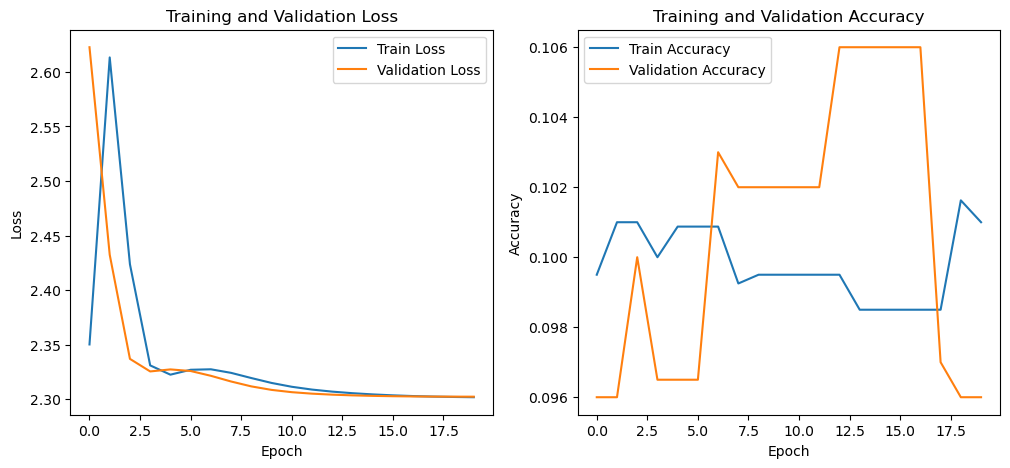

In [48]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

## Results: Sigmoid Activation

The model trained with Sigmoid activation shows very slow convergence.
The training loss remains close to the theoretical maximum for multi-class
classification, and validation accuracy remains close to random guessing (~10%).

This behaviour is consistent with the vanishing gradient problem associated
with Sigmoid activations in deeper networks.
